In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

In [2]:
# Load the dataset
data = pd.read_csv('./datasets/mushroom.csv')
display(data.head())

# Uncomment below to forcefully unbalance your dataset.
data = data[~data.index.isin(data[data['class'] ==  'p'].sample(2500).index)]

print(data['class'].value_counts())

enc = {'e': 0, 'p': 1}
data['class'] = data['class'].map(enc)
print(data['class'].value_counts())

print(data['class'].value_counts(normalize=True)*100)

,class,cap-shape,cap-surface,cap-color,ruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,e,x,f,n,f,n,f,w,n,b,...,y,w,p,NaN,n,o,p,w,v,NaN
1,p,NaN,y,g,t,NaN,f,c,b,k,...,s,n,c,p,w,n,e,NaN,y,g
2,e,b,y,n,t,n,f,c,NaN,n,...,s,p,NaN,p,w,o,p,b,y,w
3,e,x,g,g,t,n,f,w,b,n,...,s,p,NaN,p,w,n,n,NaN,NaN,d
4,e,NaN,f,NaN,t,n,a,w,n,n,...,k,NaN,w,p,w,NaN,l,w,v,d


class
e    14354
p     9132
Name: count, dtype: int64
class
0    14354
1     9132
Name: count, dtype: int64
class
0    61.117261
1    38.882739
Name: proportion, dtype: float64


In [3]:
# Assuming 'class' is the target variable and all other columns are features
X = data[['cap-surface', 'gill-attachment','stalk-root', 'habitat']]
y = data['class']

# Identify categorical and numerical columns
# For this example, let's assume all columns are categorical
categorical_features = X.columns.tolist()
# If there are numerical features, specify them here:
# numerical_features = ['num_feature1', 'num_feature2', ...]

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4, stratify = y)

enc = OneHotEncoder(drop = 'first',handle_unknown="ignore",sparse_output=False,)
X_train = enc.fit_transform(X_train)
X_test = enc.transform(X_test)

X_train.shape , X_test.shape

((17614, 18), (5872, 18))

## First we will fit the model with default parameters only.

**LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='deprecated', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)**

In this example, as we have two classes in target variable we wont change following parameter through out the code.

**multi_class = ’auto’ (default)**  {‘auto’, ‘ovr’, ‘multinomial’}

ovr - one vs rest (multi class.. n_classes >= 3)

multinomial - multi class (n_classes >= 3)

**tol=0.0001**

Tolerance for the optimization. When the loss or score is not improving by at least tol for two consecutive iterations, 
convergence is considered to be reached and training stops.

*convergence - convergence refers to the point at which the training process reaches a stable state and the parameters of the network(e.g. weights and biases) have settled on values that produce accurate predictions for the training data.
An ML algorithm is said to converge(learns) when as the iterations proceed, the output gets closer and closer to a specific value.

In [5]:
# Fit the model
log_reg = LogisticRegression(penalty = None, random_state=4)
log_reg.fit(X_train,y_train)

# Evaluate the model on the test set
y_pred = log_reg.predict(X_train)
y_pred_proba = log_reg.predict_proba(X_train)[:, 1]  # Probability estimates for the positive class

# Calculate precision, recall, and AUC
precision = precision_score(y_train, y_pred)  # Adjust pos_label if 'e' is not the positive class
recall = recall_score(y_train, y_pred)        # Adjust pos_label if 'e' is not the positive class
auc = roc_auc_score(y_train, y_pred_proba)

# Generate classification report
class_report = classification_report(y_train, y_pred)

print(f"Test set precision: {precision.round(5)}")
print(f"Test set recall: {recall.round(5)}")
print(f"Test set AUC: {auc.round(5)}")
print(f"Test set Classification report:\n{class_report}")

Test set precision: 0.71429
Test set recall: 0.00073
Test set AUC: 0.55384
Test set Classification report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.76     10765
           1       0.71      0.00      0.00      6849

    accuracy                           0.61     17614
   macro avg       0.66      0.50      0.38     17614
weighted avg       0.65      0.61      0.46     17614



## The main hyperparameters we may tune in logistic regression are:   solver, penalty, and regularization strength

## Solver 

**default = ’lbfgs’.**

Solver is the algorithm to use in the optimization problem. 

Each solver tries to find the parameter weights that minimize a cost function.

Scikit-learn ships with five different solvers {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}. 
 
lbfgs - relatively performs well compared to other methods and it saves a lot of memory, however, sometimes it may have issues with convergence.

sag - faster than other solvers for large datasets, when both the number of samples and the number of features are large.

saga - the solver of choice for sparse multinomial logistic regression and it’s also suitable for very large datasets.

newton-cg - computationally expensive because of the Hessian Matrix.

liblinear- recommended when you have a high dimension dataset - solving large-scale classification problems.

In [6]:
# Fit the model
# 'liblinear' not tried as it gives error when penalty is None.
solver = ['newton-cg', 'lbfgs', 'sag', 'saga']
row_index = 1
clf_columns=[]
clf_compare = pd.DataFrame(columns = clf_columns)

for s in solver:
    log_reg = LogisticRegression(solver= s, penalty = None, max_iter=1000, random_state=12)
    log_reg.fit(X_train,y_train)

    # Evaluate the model on the test set
    y_pred = log_reg.predict(X_train)
    y_pred_proba = log_reg.predict_proba(X_train)[:, 1]  # Probability estimates for the positive class
    
    # Calculate precision, recall, and AUC
    score = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)  # Adjust pos_label if 'e' is not the positive class
    recall = recall_score(y_train, y_pred)        # Adjust pos_label if 'e' is not the positive class
    auc = roc_auc_score(y_train, y_pred_proba)
    
    clf_compare.loc[row_index, 'Solver'] = s
    clf_compare.loc[row_index, 'Test Accuracy'] = round(score,5)
    clf_compare.loc[row_index, 'Precision'] = round(precision,5)
    clf_compare.loc[row_index, 'Recall'] = round(recall,5)
    clf_compare.loc[row_index, 'auc'] = round(auc,5)
    
    row_index+=1

clf_compare

,Solver,Test Accuracy,Precision,Recall,auc
1,newton-cg,0.61133,0.57895,0.00161,0.55384
2,lbfgs,0.61133,0.71429,0.00073,0.55384
3,sag,0.61133,0.57895,0.00161,0.55388
4,saga,0.61133,0.57895,0.00161,0.55388


### What we observe here is that regardless of the solver we choose, the model metric improvement vs baseline is approx 0.

## 3. Testing Logistic Regression Solvers with Penalties

penalty{‘l1’, ‘l2’, ‘elasticnet’, None}, default=’l2’

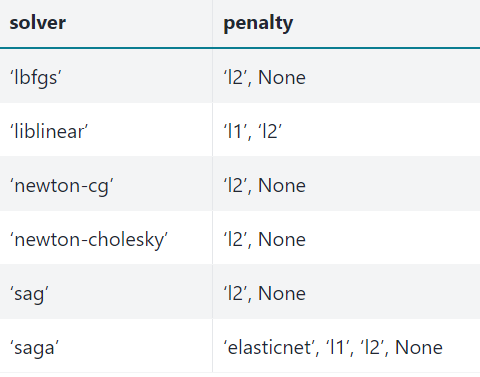

## 'l2', 'l1' penalty

By adding a penalty term to the objective function, regularization forces the coefficients (weights) of the model to be small. 
This reduces the complexity of the model and makes it less prone to overfitting.

For example, if we have a model with a large number of features, regularization can help to reduce the number of non-zero coefficients and simplify the model.

L2 regularization is less prone to overfitting than L1 regularization and is often used as a default choice.

In [7]:
# Fit the model
# Added 'liblinear' as penalty is changed to 'l2'
solver = ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga']

row_index = 1
clf_columns=[]
clf_compare = pd.DataFrame(columns = clf_columns)

for s in solver:
    log_reg = LogisticRegression(solver= s, penalty = 'l2', max_iter=1000, random_state=12)
    log_reg.fit(X_train,y_train)

    # Evaluate the model on the test set
    y_pred = log_reg.predict(X_train)
    y_pred_proba = log_reg.predict_proba(X_train)[:, 1]  # Probability estimates for the positive class

    # Calculate precision, recall, and AUC
    score = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)  # Adjust pos_label if 'e' is not the positive class
    recall = recall_score(y_train, y_pred)        # Adjust pos_label if 'e' is not the positive class
    auc = roc_auc_score(y_train, y_pred_proba)
    
    clf_compare.loc[row_index, 'Solver'] = s
    clf_compare.loc[row_index, 'Test Accuracy'] = round(score,5)
    clf_compare.loc[row_index, 'Precision'] = round(precision,5)
    clf_compare.loc[row_index, 'Recall'] = round(recall,5)
    clf_compare.loc[row_index, 'auc'] = round(auc,5)
    
    row_index+=1

clf_compare

/opt/mambaforge/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mambaforge/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Solver,Test Accuracy,Precision,Recall,auc
1,newton-cg,0.61116,0.00000,0.00000,0.55383
2,lbfgs,0.61116,0.00000,0.00000,0.55385
3,liblinear,0.61133,0.71429,0.00073,0.55386
4,sag,0.61133,0.71429,0.00073,0.55391
5,saga,0.61133,0.71429,0.00073,0.55391


In [8]:
# Fit the model
# WIth l1 penalty
solver = ['liblinear', 'saga']

row_index = 1
clf_columns=[]
clf_compare = pd.DataFrame(columns = clf_columns)
for s in solver:
    log_reg = LogisticRegression(solver= s, penalty = 'l1', max_iter=1000, random_state=12)
    log_reg.fit(X_train,y_train)

    # Evaluate the model on the test set
    y_pred = log_reg.predict(X_train)
    y_pred_proba = log_reg.predict_proba(X_train)[:, 1]  # Probability estimates for the positive class

   # Calculate precision, recall, and AUC
    score = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)  # Adjust pos_label if 'e' is not the positive class
    recall = recall_score(y_train, y_pred)        # Adjust pos_label if 'e' is not the positive class
    auc = roc_auc_score(y_train, y_pred_proba)
    
    clf_compare.loc[row_index, 'Solver'] = s
    clf_compare.loc[row_index, 'Test Accuracy'] = round(score,5)
    clf_compare.loc[row_index, 'Precision'] = round(precision,5)
    clf_compare.loc[row_index, 'Recall'] = round(recall,5)
    clf_compare.loc[row_index, 'auc'] = round(auc,5)
    
    row_index+=1

clf_compare

/opt/mambaforge/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mambaforge/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Solver,Test Accuracy,Precision,Recall,auc
1,liblinear,0.61116,0.0,0.0,0.55390
2,saga,0.61116,0.0,0.0,0.55392


## Testing C parameter

**"C" : float, default=1.0**

Finally, we introduce C (default is 1) which is a penalty term, meant to disincentivize and regulate overfitting. 

To use regularization, we need to set the “penalty” hyperparameter to “l1”, “l2”, or “elasticnet” and the “C” hyperparameter to the regularization strength.

The “C” hyperparameter controls the strength of the regularization.

A smaller value for “C” (e.g. C=0.01) leads to stronger regularization and a simpler model, while a larger value (e.g. C=1.0) leads to weaker regularization and a more complex model.

In [9]:
solver = ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga']
c = [0.01,0.1,1]
row_index = 1

for s in solver:
    clf_columns=[]
    clf_compare = pd.DataFrame(columns = clf_columns)
    for c_value in c:
        log_reg = LogisticRegression(solver= s, penalty = 'l2', C = c_value, max_iter=1000, random_state=12)
        log_reg.fit(X_train,y_train)

        # Evaluate the model on the test set
        y_pred = log_reg.predict(X_train)
        y_pred_proba = log_reg.predict_proba(X_train)[:, 1]  # Probability estimates for the positive class

       # Calculate precision, recall, and AUC
        score = accuracy_score(y_train, y_pred)
        precision = precision_score(y_train, y_pred)  # Adjust pos_label if 'e' is not the positive class
        recall = recall_score(y_train, y_pred)        # Adjust pos_label if 'e' is not the positive class
        auc = roc_auc_score(y_train, y_pred_proba)
    
        clf_compare.loc[row_index, 'Solver'] = s
        clf_compare.loc[row_index, 'C value'] = c_value
        clf_compare.loc[row_index, 'Test Accuracy'] = round(score,5)
        clf_compare.loc[row_index, 'Precision'] = round(precision,5)
        clf_compare.loc[row_index, 'Recall'] = round(recall,5)
        clf_compare.loc[row_index, 'auc'] = round(auc,5)
    
        row_index+=1
        
    print("\n",clf_compare)

/opt/mambaforge/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mambaforge/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mambaforge/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt


       Solver  C value  Test Accuracy  Precision  Recall      auc
1  newton-cg     0.01        0.61116        0.0     0.0  0.55293
2  newton-cg     0.10        0.61116        0.0     0.0  0.55374
3  newton-cg     1.00        0.61116        0.0     0.0  0.55383


/opt/mambaforge/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mambaforge/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mambaforge/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



   Solver  C value  Test Accuracy  Precision  Recall      auc
4  lbfgs     0.01        0.61116        0.0     0.0  0.55292
5  lbfgs     0.10        0.61116        0.0     0.0  0.55371
6  lbfgs     1.00        0.61116        0.0     0.0  0.55385

       Solver  C value  Test Accuracy  Precision   Recall      auc
7  liblinear     0.01        0.61116    0.00000  0.00000  0.55081
8  liblinear     0.10        0.61116    0.00000  0.00000  0.55361
9  liblinear     1.00        0.61133    0.71429  0.00073  0.55386


/opt/mambaforge/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mambaforge/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



    Solver  C value  Test Accuracy  Precision   Recall      auc
10    sag     0.01        0.61116    0.00000  0.00000  0.55290
11    sag     0.10        0.61116    0.00000  0.00000  0.55375
12    sag     1.00        0.61133    0.71429  0.00073  0.55391


/opt/mambaforge/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mambaforge/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



    Solver  C value  Test Accuracy  Precision   Recall      auc
13   saga     0.01        0.61116    0.00000  0.00000  0.55290
14   saga     0.10        0.61116    0.00000  0.00000  0.55374
15   saga     1.00        0.61133    0.71429  0.00073  0.55391


## from Sklearn library - 

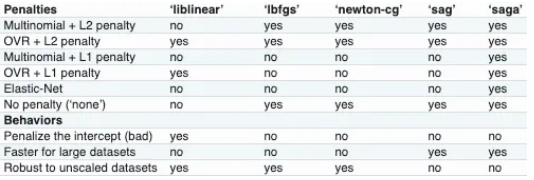